In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasRegressor
import glob


In [2]:
# test if cuDNN is working
# if it work it will have result like this...
# [name: "/device:CPU:0"
# device_type: "CPU"
# memory_limit: 268435456
# locality {
# }
# incarnation: 4781403691439849427
# xla_global_id: -1
# , name: "/device:GPU:0"
# device_type: "GPU"
# memory_limit: 4185718784
# locality {
#   bus_id: 1
#   links {
#   }
# }
# incarnation: 7340527517201123542
# physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
# xla_global_id: 416903419
# ]

# the last bottom part of above result is very important, IT MUST HAVE!

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
path = './assets/face_mini'
filenames = glob.glob(path + '/**/*.jpg', recursive=True)
print(filenames[0])

./assets/face_mini\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


# 6.1 Preprocessing

In [4]:
warehouse = []

In [5]:
for pth in filenames:
    img = image.load_img(pth, target_size=(100,100,3), interpolation="nearest")
    img = image.img_to_array(img)
    img = img/255.1
    warehouse.append(img)

In [6]:
warehouse = np.array(warehouse)
warehouse.shape

(3203, 100, 100, 3)

In [7]:
# (3203)
# 70 (2242): 30 (961) from test_size parameter
train_x,test_x = train_test_split(warehouse, random_state=32, test_size=0.3)
# (2242)
# 70 (1569): 30 (673)
train_x,val_x = train_test_split(train_x, random_state=32, test_size=0.3)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1569, 100, 100, 3)
(673, 100, 100, 3)
(961, 100, 100, 3)


# 6.1.2 Adding a Noise

In [8]:
noise_factor = [0.25, 0.75]

In [9]:
Ndist = 'normal'
Nmean = 0
Nstd  = 1

In [10]:
x_train_noisy = train_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape))
x_val_noisy   = val_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape))
x_test_noisy  = test_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


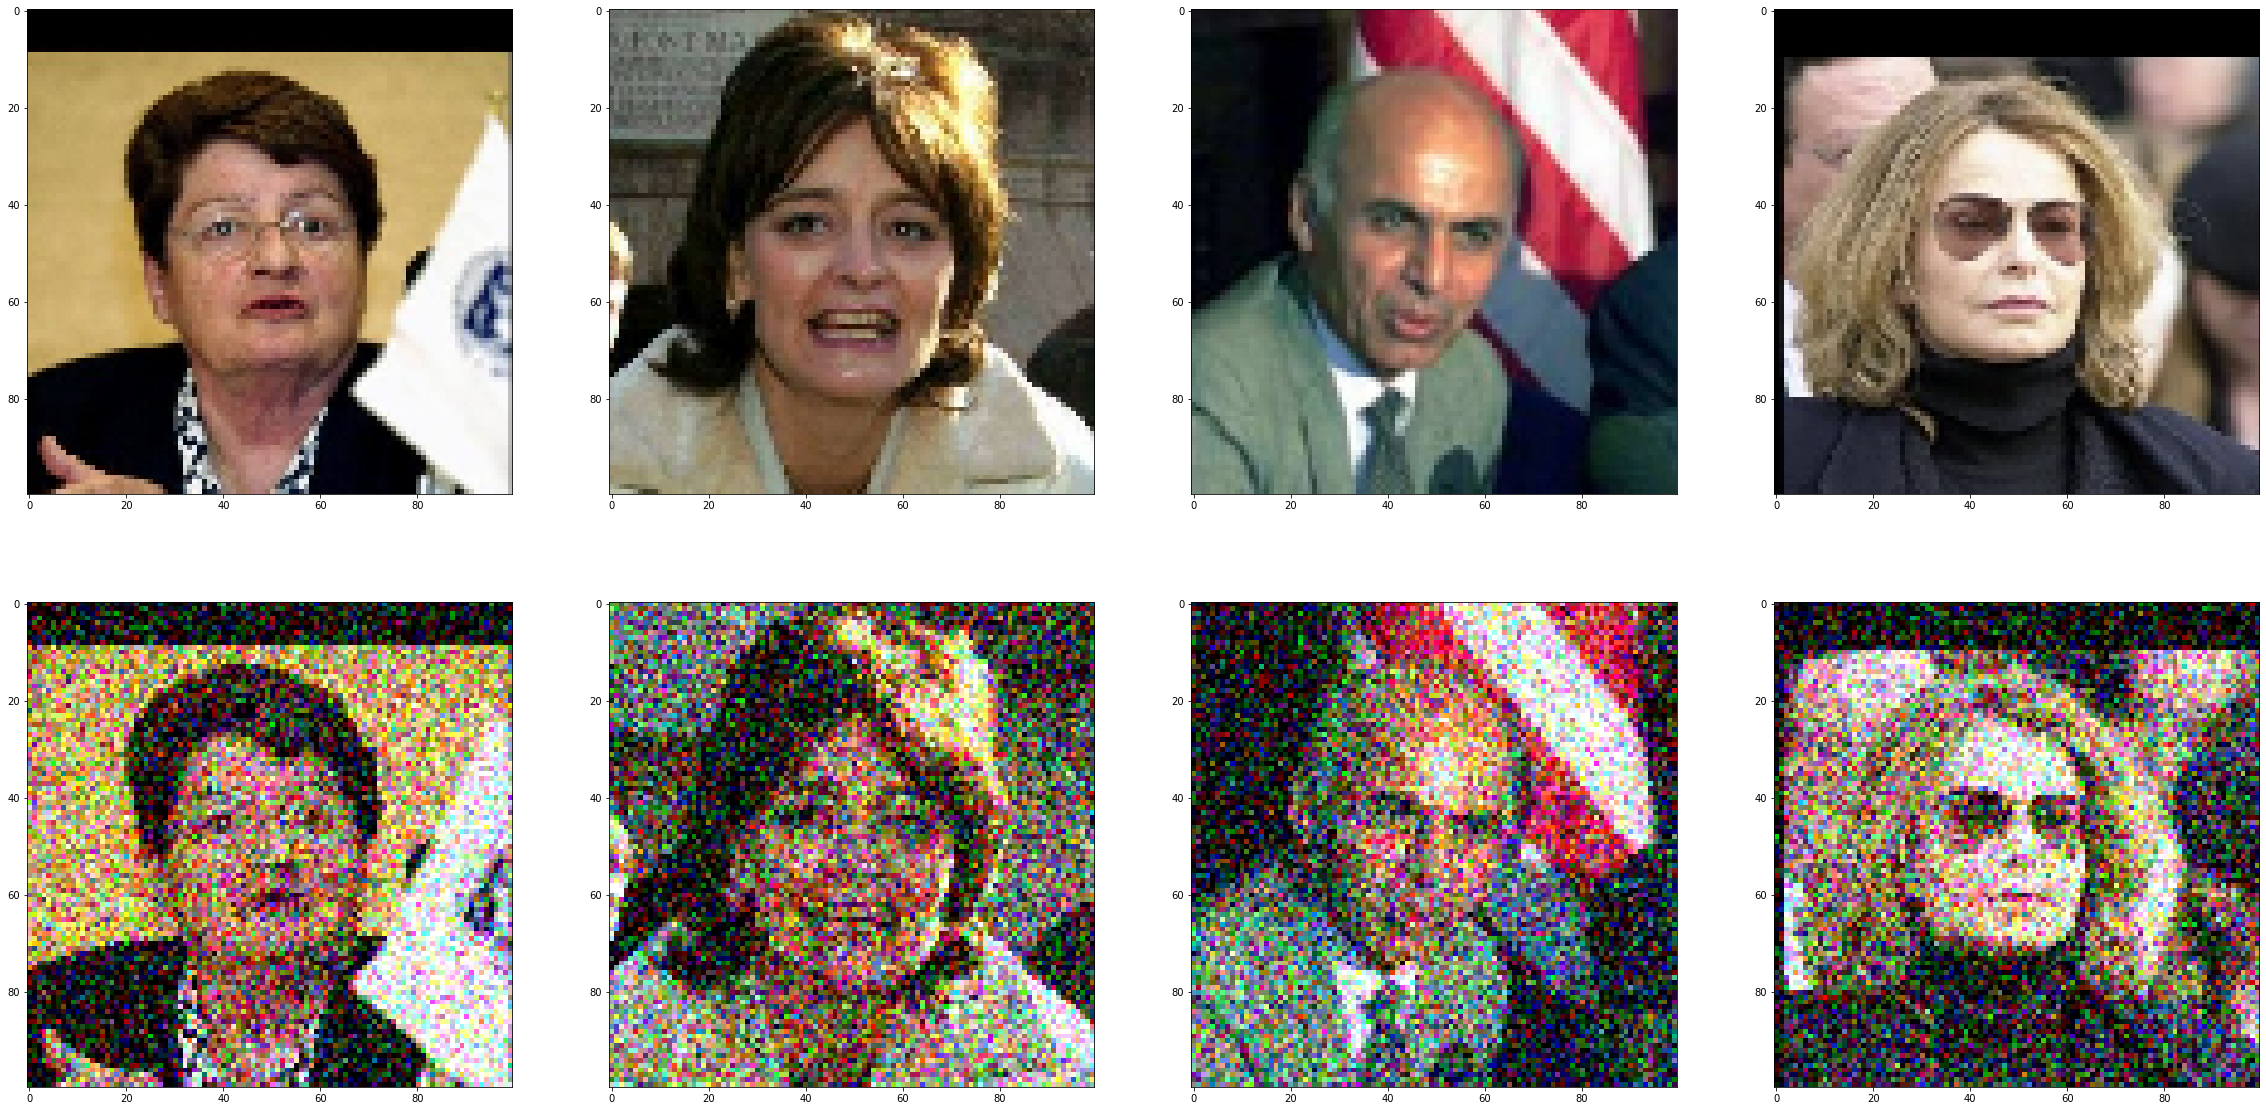

In [11]:
f, ax = plt.subplots(2,4, figsize=(40,20))
for i in range(4):
    img = train_x[i]
    ax[0,i].imshow(img)
for i in range(4):
    img_noisy = x_train_noisy[i]
    ax[1,i].imshow(img_noisy)
plt.show()

# 6.2 AutoEncoder

### AutoEncoder

In [12]:
def create_model(optimizer='adam',shape=(100,100,3)):
    # encoded
    input_img = Input(shape=shape)
    x1 = Conv2D(256,(3,3),activation='relu',padding='same')(input_img)
    x2 = Conv2D(128,(3,3),activation='relu',padding='same')(x1)
    x2 = MaxPool2D((2,2))(x2)
    encoded = Conv2D(64,(3,3),activation='relu',padding='same')(x2)
    # decoded
    x3 = Conv2D(64,(3,3),activation='relu',padding='same')(encoded)
    x3 = UpSampling2D((2,2))(x3)
    x2 = Conv2D(128,(3,3),activation='relu',padding='same')(x3)
    x1 = Conv2D(256,(3,3),activation='relu',padding='same')(x2)
    decoded = Conv2D(3,(3,3),padding='same')(x1)
    
    autoencoder = Model(input_img,decoded)
    autoencoder.compile(optimizer=optimizer,loss='mse',metrics=['mse'])
    
    return autoencoder

# Modeling

In [13]:
def printResult(grid_result):
    print('Best Params',grid_result.best_params_)
    print('Best Score',grid_result.best_score_)
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    
    return means, stds, params

In [14]:
def dictToString(dict):   
    return list(map(lambda x: 'B{0}|E{1}|O{2}'.format(x['batch_size'],x['epochs'],x['optimizer'])  ,dict))

### GridSearchCV

In [15]:
model = KerasRegressor(build_fn=create_model,epochs=2,batch_size=16,verbose=0)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26688\4144440281.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model,epochs=2,batch_size=16,verbose=0)


In [16]:
optimizer = ["SGD","RMSprop","Adadelta","Adam"]
batch_size = [8,16,32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size,epochs=epochs,optimizer=optimizer)

In [17]:
grid = GridSearchCV(estimator=model,
                    verbose=0,
                    cv=2,
#                     random_state=10,
                    param_grid=param_grid)

In [18]:
grid_result = grid.fit(x_train_noisy,train_x)

C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\k

In [37]:
means, stds, params = printResult(grid_result)

Best Params {'batch_size': 16, 'epochs': 6, 'optimizer': 'Adam'}
Best Score -0.003906411468051374


In [38]:
_params = dictToString(params)

In [39]:
grid_result.cv_results_

{'mean_fit_time': array([21.99739063, 19.45985794, 18.70277762, 18.7725203 , 37.35711837,
        41.03927505, 40.06992257, 39.61818922, 61.99394977, 63.33170152,
        63.12060499, 62.01706338, 19.5523572 , 17.93094134, 17.66261923,
        16.40998018, 32.67676151, 34.1535387 , 33.72084284, 33.08873868,
        50.43930423, 51.32235944, 51.28059459, 50.02441871, 28.22186792,
        12.59421659, 23.38999355, 23.62347972, 43.44761467, 32.42651618,
        11.31776226, 44.31093442, 69.87387371, 70.04623675, 70.79403794,
        40.33405244]),
 'std_fit_time': array([1.87434995e+00, 5.62972546e-01, 3.49354744e-03, 2.51702547e-01,
        4.89360809e-01, 1.70054209e+00, 4.60852504e-01, 2.59457946e-01,
        1.42295134e+00, 4.02790546e-01, 4.57349777e-01, 2.98897028e-01,
        1.88426566e+00, 7.08994865e-02, 3.46199274e-02, 6.65385127e-01,
        1.50107515e+00, 8.09788704e-02, 1.07794523e-01, 2.08500147e-01,
        2.26674438e-01, 2.23818183e-01, 3.40667963e-01, 4.89431620e-02,
 

In [117]:
def find_percentile(lst):
	onethirdth, twothirdth = np.percentile(lst, [33.33, 66.66])
	import math
	if (math.isnan(onethirdth) or math.isnan(twothirdth)):
		len_values = len(lst)
		first = len_values * (1/3)
		second = len_values * (2/3)
		first = round(first, 0)
		second = round(second, 0)
		for index, value in enumerate(lst):
			if (index == first):
				if (not (math.isnan(value))):
					onethirdth = value
				else:
					first += 1
			if (index == second):
				if (not (math.isnan(value))):
					twothirdth = value
				else:
					second += 1
	return onethirdth, twothirdth

In [118]:

def color_calulate_negative(value, lst):
	onethirdth, twothirdth = find_percentile(lst)
	if (value < onethirdth):
		return "red"
	elif (value < twothirdth):
		return "blue"
	else:
		return "green"

In [120]:
def color_calulate_positive(value, lst):
	onethirdth, twothirdth = find_percentile(lst)

	# print(onethirdth, twothirdth)
	if (value < onethirdth):
		return "green"
	elif (value < twothirdth):
		return "blue"
	else:
		return "red"

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


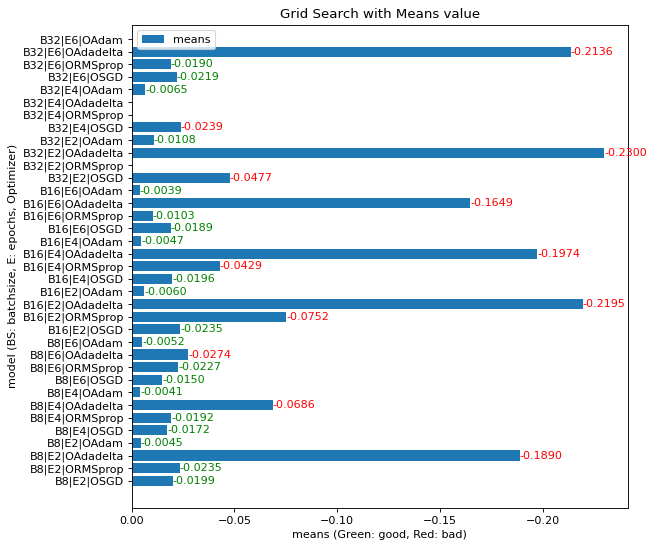

In [121]:
plt.figure(figsize=(8,8), dpi=80)
plt.barh(_params,means)
plt.title('Grid Search with Means value') 
plt.ylabel('model (BS: batchsize, E: epochs, Optimizer)')
plt.xlabel('means (Green: good, Red: bad)')
plt.gca().invert_xaxis()
plt.legend(['means'], loc='upper left')

# plot every value with color
for index, value in enumerate(means):
    plt.text(value, index, str("{:.4f}".format(value)), color = color_calulate_negative(value, means), va = 'center') 
    
plt.show()


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


[1.33208930e-04 1.11483131e-02 5.24138659e-03 9.66293737e-05
 3.04040499e-04 1.23470607e-02 3.20157707e-02 4.52453736e-04
 6.10154122e-04 1.61187898e-02 9.83653590e-04 1.69823423e-03
 1.36114378e-03 1.59405749e-02 8.15499574e-03 3.24544962e-05
 7.81325623e-04 6.05735369e-03 2.82811373e-03 7.38492236e-05
 2.46491283e-04 3.31020192e-03 1.11056268e-02 2.92282202e-04
 5.93360886e-03            nan 1.65346265e-03 3.74688744e-03
 6.27981499e-04            nan            nan 9.30926763e-05
 1.87990256e-04 2.13905238e-04 1.78083852e-02            nan]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


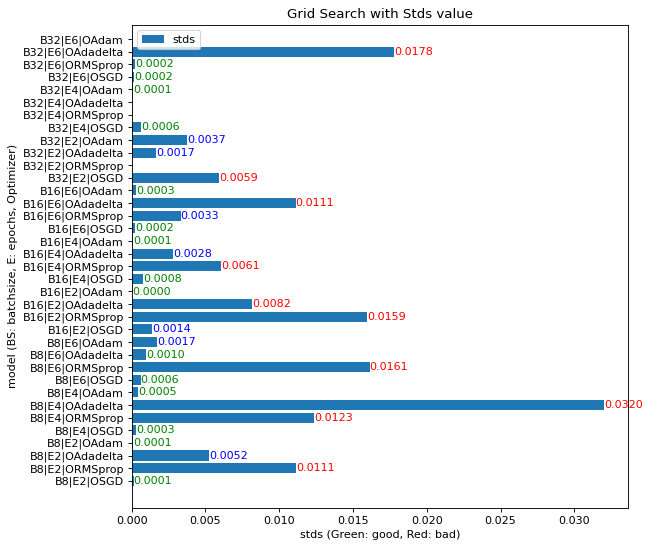

In [122]:
plt.figure(figsize=(8,8), dpi=80)
plt.barh(_params,stds)
plt.title('Grid Search with Stds value') 
plt.ylabel('model (BS: batchsize, E: epochs, Optimizer)')
plt.xlabel('stds (Green: good, Red: bad)')
plt.legend(['stds'], loc='upper left')

# plot every value with color
for index, value in enumerate(stds):
    plt.text(value, index, str("{:.4f}".format(value)), color = color_calulate_positive(value, stds), va = 'center') 

print(stds)
plt.show()

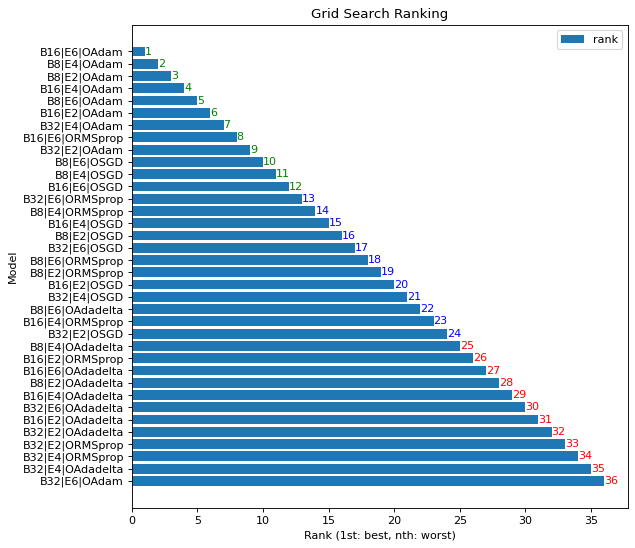

In [123]:
y_rank, x_model = zip(*sorted(zip( grid_result.cv_results_['rank_test_score'], _params)))

plt.figure(figsize=(8,8), dpi=80)
plt.barh(x_model, y_rank)
plt.title('Grid Search Ranking') 
plt.ylabel('Model')
plt.xlabel('Rank (1st: best, nth: worst)')
plt.gca().invert_yaxis()
plt.legend(['rank'], loc='upper right')

# plot every value with color
for index, value in enumerate(y_rank):
    plt.text(value, index, str(value), color = color_calulate_positive(value, y_rank), va = 'center') 

plt.show()

### RandomizedSearchCV

In [28]:
grid_rand = RandomizedSearchCV(estimator=model,
                            verbose=0,
                            cv=2,
                            random_state=10,
                            n_iter=10,
                            param_distributions=param_grid)

In [29]:
grid_rand_result = grid_rand.fit(x_train_noisy,train_x)

In [30]:
means, stds, params = printResult(grid_rand_result)

Best Params {'optimizer': 'Adam', 'epochs': 4, 'batch_size': 8}
Best Score -0.003880738280713558


In [31]:
grid_rand_result.cv_results_

{'mean_fit_time': array([23.84021938, 42.43738461, 18.88806927, 15.39737153, 36.54369938,
        38.14408231, 62.89981568, 21.49362183, 17.2343905 , 32.5125457 ]),
 'std_fit_time': array([0.4085778 , 0.92447925, 0.14784014, 0.02710605, 0.26737487,
        0.38626552, 0.0862118 , 0.97781444, 0.13932633, 0.02005231]),
 'mean_score_time': array([3.43538702, 3.19374299, 4.13344646, 3.18597651, 4.08636069,
        4.02336121, 3.19945836, 4.78705215, 3.36807704, 3.45051157]),
 'std_score_time': array([0.02848399, 0.04222322, 0.02984333, 0.01495695, 0.05722904,
        0.04414129, 0.03653598, 0.14089584, 0.00892591, 0.01247036]),
 'param_optimizer': masked_array(data=['SGD', 'Adam', 'Adadelta', 'SGD', 'Adam', 'RMSprop',
                    'SGD', 'Adam', 'RMSprop', 'Adadelta'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[2, 4, 2, 2, 4, 4, 

In [32]:
_params = dictToString(params)

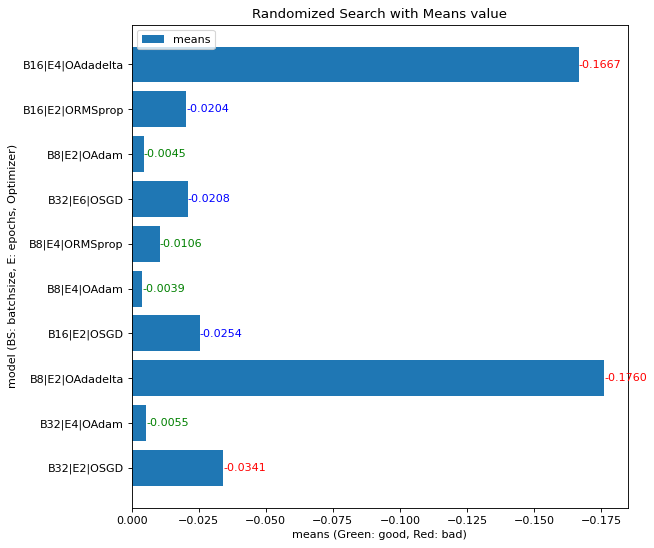

In [33]:
plt.figure(figsize=(8,8), dpi=80)
plt.barh(_params, means)
plt.title('Randomized Search with Means value') 
plt.ylabel('model (BS: batchsize, E: epochs, Optimizer)')
plt.xlabel('means (Green: good, Red: bad)')
plt.gca().invert_xaxis()
plt.legend(['means'], loc='upper left')

# plot every value with color
for index, value in enumerate(means):
    plt.text(value, index, str("{:.4f}".format(value)), color = color_calulate_negative(value, means), va = 'center') 

plt.show()

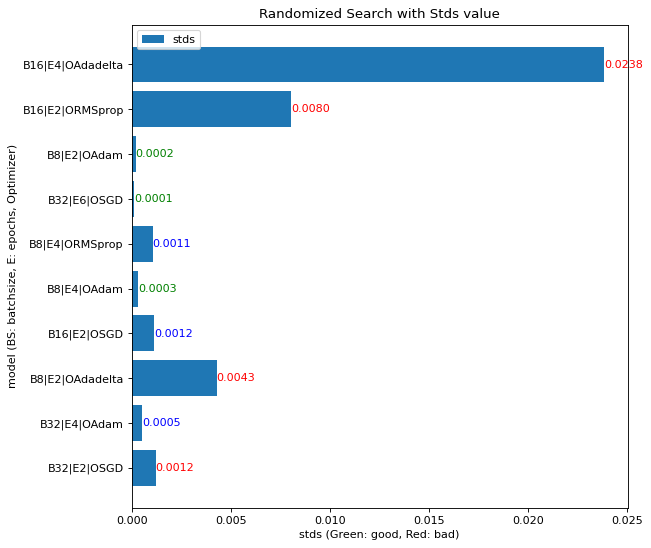

In [34]:
plt.figure(figsize=(8,8), dpi=80)
plt.barh(_params,stds)
plt.title('Randomized Search with Stds value') 
plt.ylabel('model (BS: batchsize, E: epochs, Optimizer)')
plt.xlabel('stds (Green: good, Red: bad)')
plt.legend(['stds'], loc='upper left')

# plot every value with color
for index, value in enumerate(stds):
    plt.text(value, index, str("{:.4f}".format(value)), color = color_calulate_positive(value, stds), va = 'center') 

plt.show()

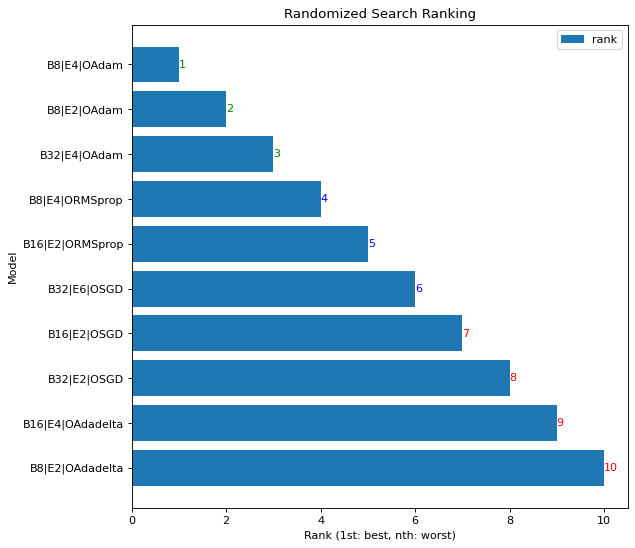

In [35]:
y_rank, x_model = zip(*sorted(zip( grid_rand_result.cv_results_['rank_test_score'], _params)))

plt.figure(figsize=(8,8), dpi=80)
plt.barh(x_model, y_rank)
plt.title('Randomized Search Ranking') 
plt.ylabel('Model')
plt.xlabel('Rank (1st: best, nth: worst)')
plt.gca().invert_yaxis()
plt.legend(['rank'], loc='upper right')

# plot every value with color
for index, value in enumerate(y_rank):
    plt.text(value, index, str(value), color = color_calulate_positive(value, y_rank), va = 'center') 

plt.show()